# A/B Testing for LunarTech Homepage's CTA Button

## Table of Contents

- [1. Loading & Exploring Data](#1.-Loading-&-Exploring-Data)
- [2. Setting Parameters & Calculating Group Statistics](#2.-Setting-Parameters-&-Calculating-Group-Statistics)
- [3. Calculating Estimates & Z-Test Values](#3.-Calculating-Estimates-&-Z-Test-Values)
- [4. Checking & Visualizing Statistical Significance](#4.-Checking-&-Visualizing-Statistical-Significance)
- [5. Checking Practical Significance](#5.-Checking-Practical-Significance)

## 1. Loading & Exploring Data

In [1]:
# Import libraries for statistical analysis and visualization
from scipy.stats import norm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Load and display the first few rows of the A/B test data
ab_test = pd.read_csv('User_Data.csv')
ab_test.head()

,user_id,click,group,timestamp
0,1,1,exp,2024-01-01 00:00:00
1,2,0,exp,2024-01-01 00:01:00
2,3,1,exp,2024-01-01 00:02:00
3,4,0,exp,2024-01-01 00:03:00
4,5,1,exp,2024-01-01 00:04:00


In [2]:
# Display summary statistics and total clicks by group
display(ab_test.describe())
display(ab_test.groupby("group")["click"].sum("click"))

,user_id,click
count,20000.000000,20000.000000
mean,10000.500000,0.405250
std,5773.647028,0.490953
min,1.000000,0.000000
25%,5000.750000,0.000000
50%,10000.500000,0.000000
75%,15000.250000,1.000000
max,20000.000000,1.000000


group
con    1989
exp    6116
Name: click, dtype: int64

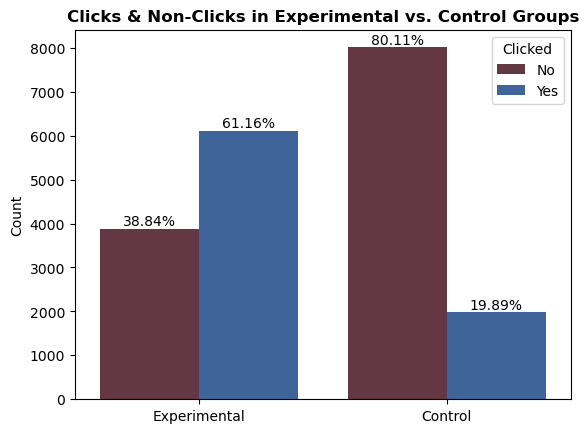

In [3]:
# Plot count of clicks in experimental vs. control groups
plt.figure()
ax = sns.countplot(data=ab_test, x='group', hue='click', palette={0: '#6C2F41', 1: '#3062A8'})

plt.title('Clicks & Non-Clicks in Experimental vs. Control Groups', weight='bold')
plt.ylabel('Count')
plt.xlabel('')
plt.legend(title='Clicked', labels=['No', 'Yes'])

ax.set_xticks([0, 1])
ax.set_xticklabels(['Experimental', 'Control'])


# Annotate bars with percentage of clicks and non-clicks for each group
group_counts = ab_test.groupby('group')['user_id'].count()

for bar in ax.patches:
    bar_height = bar.get_height()
    
    if bar_height > 0:
        position = (bar.get_width() / 2) + bar.get_x()
        group_label = ab_test['group'].unique()[int(bar.get_x())]
        
        percentage = f"{bar_height / group_counts.loc[group_label] * 100:.2f}%"
        ax.annotate(percentage, (position, bar_height), ha='center', va='bottom', color='black', fontsize=10)

plt.show()

## 2. Setting Parameters & Calculating Group Statistics

In [4]:
# Set and display significance level and minimum detectable effect
alpha = 0.05
delta = 0.1

print("Significance level (α):", alpha)
print("Minimum detectable effect (δ):", delta)

Significance level (α): 0.05
Minimum detectable effect (δ): 0.1


In [5]:
# Calculate and display group statistics: number of users and total clicks
N_control = ab_test[ab_test["group"] == "con"]["user_id"].count()
N_experimental = ab_test[ab_test["group"] == "exp"]["user_id"].count()

X_control = ab_test.groupby("group")["click"].sum().loc["con"]
X_experimental = ab_test.groupby("group")["click"].sum().loc["exp"]

print("Number of users in control group:", N_control)
print("Number of users in experimental group:", N_experimental)
print("Total clicks in control group:", X_control)
print("Total clicks in experimental group:", X_experimental)

Number of users in control group: 10000
Number of users in experimental group: 10000
Total clicks in control group: 1989
Total clicks in experimental group: 6116


## 3. Calculating Estimates & Z-Test Values

In [6]:
# Calculate and display click probability estimates for both groups
con_p_hat = X_control / N_control
exp_p_hat = X_experimental / N_experimental
print("Click probability estimate in control group:", con_p_hat)
print("Click probability estimate in experimental group:", exp_p_hat, end="\n\n")

# Calculate and display pooled click probability and variance estimates
pooled_p_hat = (X_control + X_experimental) / (N_control + N_experimental)
pooled_var_hat = pooled_p_hat * (1-pooled_p_hat) * (1/N_control + 1/N_experimental)
print("Pooled click probability estimate:", pooled_p_hat.round(4))
print("Pooled click variance estimate:", pooled_var_hat.round(4))

Click probability estimate in control group: 0.1989
Click probability estimate in experimental group: 0.6116

Pooled click probability estimate: 0.4052
Pooled click variance estimate: 0.0


In [7]:
# Calculate and display standard error, Z-score, and Z-critical value
standard_error = np.sqrt(pooled_var_hat)
print("Standard error:", standard_error.round(4))

z_statistic = (con_p_hat-exp_p_hat) / standard_error
print("Z-statistic:", z_statistic.round(2))

z_critical = norm.ppf(1 - alpha/2)
print("Z-critical value:", z_critical.round(2))

Standard error: 0.0069
Z-statistic: -59.44
Z-critical value: 1.96


## 4. Checking & Visualizing Statistical Significance

In [8]:
# Define and apply function to check statistical significance
def check_statistical_significance(test_statistic, significance_level):
    
    p_value = 2 * norm.sf(abs(test_statistic))
    print(f"P-value: {p_value}")

    if p_value <= significance_level:
        print("Statistical significance found! The observed difference between the control and experimental groups is unlikely due to chance.")
    else:
        print("No statistical significance found! The observed difference between the control and experimental groups could be due to chance.")

check_statistical_significance(z_statistic, alpha)

P-value: 0.0
Statistical significance found! The observed difference between the control and experimental groups is unlikely due to chance.


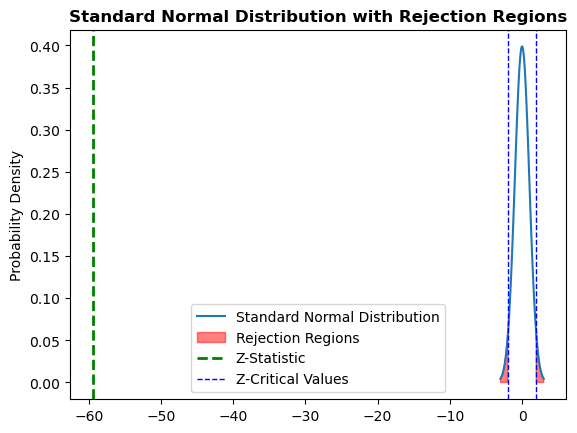

In [9]:
# Define standard normal distribution and calculate x- and y-values
mean = 0
std_dev = 1
x_values = np.linspace(mean - 3*std_dev, mean + 3*std_dev, 100)
y_values = norm.pdf(x_values, mean, std_dev)


# Plot standard normal distribution with rejection regions and Z-test values
plt.plot(x_values, y_values, label='Standard Normal Distribution')
plt.fill_between(x_values, y_values, where=(x_values > z_critical) | (x_values < -z_critical),
                 label='Rejection Regions', color='red', alpha=0.5)

plt.axvline(z_statistic, color='green', linestyle='dashed', linewidth=2, label=f'Z-Statistic')
plt.axvline(z_critical, color='blue', linestyle='dashed', linewidth=1, label=f'Z-Critical Values')
plt.axvline(-z_critical, color='blue', linestyle='dashed', linewidth=1)

plt.title('Standard Normal Distribution with Rejection Regions', weight='bold')
plt.ylabel('Probability Density')

plt.legend()
plt.show()

## 5. Checking Practical Significance

In [10]:
# Calculate and display confidence interval for the two-sample Z-test
confidence_interval = [round((exp_p_hat-con_p_hat) - standard_error*z_critical, 4),
                       round((exp_p_hat-con_p_hat) + standard_error*z_critical, 4)]

print("Confidence interval:", confidence_interval)

Confidence interval: [0.3991, 0.4263]


In [11]:
# Define and apply function to check practical significance
def check_practical_significance(min_detectable_effect, confidence_interval):
    
    lower_bound_CI = confidence_interval[0]
    
    if lower_bound_CI >= min_detectable_effect:
        print("The observed difference between the control and experimental groups is practically significant.")
    else:
        print("The observed difference between the control and experimental groups is not practically significant.")

check_practical_significance(delta, confidence_interval)

The observed difference between the control and experimental groups is practically significant.
